In [26]:
import talib
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from binance.client import Client
from binance.enums import HistoricalKlinesType

api_key = 'y9m94JvyDsSRyHZUQjNN1lVfDnduNMFyQxz83EW650XKwgbIXxB85xGv7CDQfW8Z'
api_secret = 'cHvzTpnE3Qp468ZcAIadtIQSKvV6HdbXsnwbTAhlTCg9Q0uydcxVKUwP7rqLrcpl'

klines_column_names = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 
                       'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

client = Client(api_key, api_secret, {"timeout": 500})

In [118]:
df_klines = pd.read_csv('ethusdt.1min.1-8march2022.csv', index_col='Open time')

df = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]

In [119]:
up, mid, low = talib.BBANDS(df['Close'], timeperiod=20)
df = df.assign(upperband=up, middleband=mid, lowerband=low)
df = df.dropna(axis=0)

In [141]:
initial_margin = 100

entry = None
position = None # long / short
entry_upperband = None
entry_lowerband = None

history = []

for idx, data in df.iterrows():
    if data.Close <= data.lowerband: # Long
        if position == 'short': # close position
            profit = (entry - data.Close) / entry
            initial_margin *= (1+profit)
            history.append({
                'date': idx,
                'entry': entry,
                'exit' : data.Close,
                'profit' : profit * 100,
                'loss' : None,
                'position' : position,
                'margin' : initial_margin,
                'entry_upperband' : entry_upperband,
                'entry_lowerband' : entry_lowerband,
                'exit_upperband': data.upperband,
                'exit_lowerband': data.lowerband,
            })
            entry = None
            position = None
            entry_upperband = None
            entry_lowerband = None
        elif position == 'long': # stoploss
            if (entry - data.Close) / entry * 100 > 2.5:
                loss = (data.Close - entry) / entry
                initial_margin *= (1+loss)
                history.append({
                    'date': idx,
                    'entry': entry,
                    'exit' : data.Close,
                    'profit' : None,
                    'loss': loss * 100,
                    'position' : position,
                    'margin' : initial_margin,
                    'entry_upperband' : entry_upperband,
                    'entry_lowerband' : entry_lowerband,
                    'exit_upperband': data.upperband,
                    'exit_lowerband': data.lowerband,
                })
                entry = None
                position = None
                entry_upperband = None
                entry_lowerband = None
        else: # enter trade
            entry = data.Close
            position = 'long'
            entry_upperband = data.upperband
            entry_lowerband = data.lowerband
        
    elif data.Close >= data.upperband: # short
        if position == 'long': # close position
            profit = (data.Close - entry) / entry
            initial_margin *= (1+profit)
            history.append({
                'date': idx,
                'entry': entry,
                'exit' : data.Close,
                'profit' : profit * 100,
                'loss': None,
                'position' : position,
                'margin' : initial_margin,
                'entry_upperband' : entry_upperband,
                'entry_lowerband' : entry_lowerband,
                'exit_upperband': data.upperband,
                'exit_lowerband': data.lowerband,
            })
            entry = None
            position = None
            entry_upperband = None
            entry_lowerband = None
        elif position == 'short': # stoploss
            if (data.Close - entry) / entry * 100 > 2.5:
                loss = (entry - data.Close) / entry
                initial_margin *= (1+loss)
                history.append({
                    'date': idx,
                    'entry': entry,
                    'exit' : data.Close,
                    'profit' : None,
                    'loss': loss * 100,
                    'position' : position,
                    'margin' : initial_margin,
                    'entry_upperband' : entry_upperband,
                    'entry_lowerband' : entry_lowerband,
                    'exit_upperband': data.upperband,
                    'exit_lowerband': data.lowerband,
                })
                entry = None
                position = None
                entry_upperband = None
                entry_lowerband = None
        else: # enter trade
            entry = data.Close
            position = 'short'
            entry_upperband = data.upperband
            entry_lowerband = data.lowerband

In [142]:
initial_margin

100.79527555821633

In [151]:
df_history = pd.DataFrame(history).set_index('date')

In [152]:
df_history.head(50)

,entry,exit,profit,loss,position,margin,entry_upperband,entry_lowerband,exit_upperband,exit_lowerband
date,,,,,,,,,,
2022-03-01 00:48:00,2957.03,2937.80,0.650315,NaN,short,100.650315,2954.089806,2933.739194,2957.476356,2939.648644
2022-03-01 03:45:00,2931.24,2907.88,-0.796932,NaN,long,99.848200,2952.834825,2934.429175,2907.764610,2896.514390
2022-03-01 04:33:00,2911.10,2910.02,0.037099,NaN,short,99.885243,2908.897943,2900.556057,2918.301748,2910.393252
2022-03-01 05:39:00,2916.89,2912.53,0.149474,NaN,short,100.034546,2916.837085,2910.608915,2920.430057,2912.815943
2022-03-01 06:50:00,2909.23,2917.54,0.285643,NaN,long,100.320287,2920.262342,2911.071658,2915.454658,2907.971342
2022-03-01 07:43:00,2919.07,2915.00,0.139428,NaN,short,100.460161,2917.387705,2907.210295,2923.512942,2916.376058
2022-03-01 08:02:00,2914.29,2924.67,0.356176,NaN,long,100.817976,2924.003831,2915.328169,2923.962980,2913.361020
2022-03-01 08:23:00,2927.47,2914.48,0.443728,NaN,short,101.265334,2926.043941,2913.558059,2928.377996,2915.459004
2022-03-01 10:34:00,2913.82,2886.99,-0.920784,NaN,long,100.332898,2928.078162,2914.393838,2886.171797,2875.105203


(-9.700000000000001, 203.7, 93.51409798276009, 109.56775184282809)

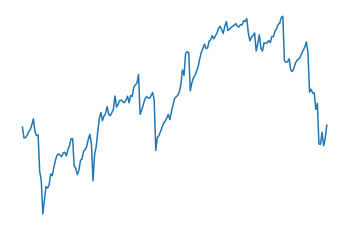

In [164]:
plt.plot(df_history.margin)
plt.axis('off')

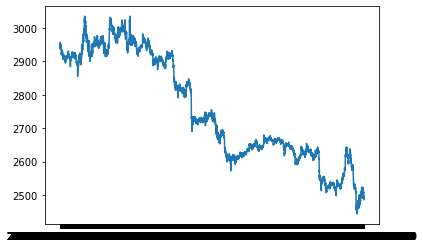

In [163]:
plt.plot(df.Close)

In [ ]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

data = yf.download(tickers='SPY', period='1d', interval='1m')
#Interval required 1 minute
data['Middle Band'] = data['Close'].rolling(window=21).mean()
data['Upper Band'] = data['Middle Band'] + 1.96*data['Close'].rolling(window=21).std()
data['Lower Band'] = data['Middle Band'] - 1.96*data['Close'].rolling(window=21).std()

#declare figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y= data['Middle Band'],line=dict(color='blue', width=.7), name = 'Middle Band'))
fig.add_trace(go.Scatter(x=data.index, y= data['Upper Band'],line=dict(color='red', width=1.5), name = 'Upper Band (Sell)'))
fig.add_trace(go.Scatter(x=data.index, y= data['Lower Band'],line=dict(color='green', width=1.5), name = 'Lower Band (Buy)'))


#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='SPY live share price evolution',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()
